# TPCC OU Data Collection

In [33]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import lightgbm as lgb
from datetime import datetime
from pathlib import Path
from scipy import stats

In [34]:
results_dir = "/home/gh/postgres/cmudb/tscout/results/tpcc"
run_dirs = sorted(os.listdir(results_dir), reverse=True)
print(f"Runs: {run_dirs}")
run_timestamp = run_dirs[0]
run_path = Path(results_dir) / run_timestamp
print(f"Taking latest run, recorded at {run_timestamp} UTC")

Runs: ['2021-11-07_03-22-21', '2021-11-07_03-18-14_AM', '2021-11-07_03-15-11_AM']
Taking latest run, recorded at 2021-11-07_03-22-21 UTC


#### Load Data

In [35]:
ou_name_to_df = dict()

for filename in os.listdir(run_path):
    if not filename.endswith(".csv"):
        continue

    filepath = os.path.join(run_path, filename)
    ou_name = filename.split(".")[0]

    if os.stat(filepath).st_size > 0:
        ou_name_to_df[ou_name] = pd.read_csv(filepath)

In [36]:
for (ou_name, ou_df) in ou_name_to_df.items():
    print(f"OU Name: {ou_name}, ou_df shape: {ou_df.shape}")

OU Name: ExecIndexScan, ou_df shape: (375952, 40)
OU Name: ExecLockRows, ou_df shape: (383213, 35)
OU Name: ExecResult, ou_df shape: (4709, 36)
OU Name: ExecValuesScan, ou_df shape: (244992, 36)
OU Name: ExecModifyTable, ou_df shape: (20041, 43)


# Pre-processing

#### Get IndexScan OU Data

In [37]:
target_ou = 'ExecIndexScan'
df = ou_name_to_df[target_ou]

#### Remove constant columns

In [38]:
cols_to_remove = []
for col in df.columns:
    if df[col].nunique() == 1: 
            cols_to_remove.append(col)

df = df.drop(cols_to_remove, axis=1)
print(f"Dropped zero-variance columns: {cols_to_remove}")
print(f"Num Remaining: {len(df.columns)}, Num Removed {len(cols_to_remove)}")

Dropped zero-variance columns: ['IndexScanState_ss_ps_type', 'IndexScanState_ss_ps_async_capable', 'IndexScanState_ss_ps_scanopsfixed', 'IndexScanState_ss_ps_outeropsfixed', 'IndexScanState_ss_ps_inneropsfixed', 'IndexScanState_ss_ps_resultopsfixed', 'IndexScanState_ss_ps_scanopsset', 'IndexScanState_ss_ps_outeropsset', 'IndexScanState_ss_ps_inneropsset', 'IndexScanState_ss_ps_resultopsset', 'IndexScanState_iss_NumOrderByKeys', 'IndexScanState_iss_ReachedEnd', 'IndexScanState_iss_PscanLen', 'Plan_type', 'Plan_plan_rows', 'Plan_plan_width', 'Plan_parallel_aware', 'Plan_parallel_safe', 'Plan_async_capable', 'Plan_plan_node_id', 'ref_cpu_cycles', 'network_bytes_read', 'network_bytes_written', 'disk_bytes_read', 'disk_bytes_written', 'memory_bytes']
Num Remaining: 14, Num Removed 26


### Remove Start/End Time (since elapsed_us == end_time - start_time)

In [39]:
df = df.drop(['start_time', 'end_time'], axis=1)

### Summarize Features

In [40]:
features = df[['IndexScanState_iss_NumScanKeys', 'IndexScanState_iss_NumRuntimeKeys', 'IndexScanState_iss_RuntimeKeysReady', 'Plan_startup_cost', 'Plan_total_cost', 'cpu_id']]
features.describe()

,IndexScanState_iss_NumScanKeys,IndexScanState_iss_NumRuntimeKeys,IndexScanState_iss_RuntimeKeysReady,Plan_startup_cost,Plan_total_cost,cpu_id
count,375952.000000,375952.000000,375952.000000,375952.000000,375952.000000,375952.000000
mean,2.273665,2.273463,0.999915,0.206690,8.227552,16.623569
std,0.651320,0.651641,0.009226,0.068352,0.067707,7.675129
min,1.000000,0.000000,0.000000,0.142500,8.162500,8.000000
25%,2.000000,2.000000,1.000000,0.145000,8.165000,10.000000
50%,2.000000,2.000000,1.000000,0.152500,8.175000,13.000000
75%,3.000000,3.000000,1.000000,0.287500,8.307500,25.000000
max,3.000000,3.000000,1.000000,0.290000,8.307500,31.000000


### Summarize Targets

In [41]:
targets = df[['cpu_cycles', 'instructions', 'cache_references', 'cache_misses', 'elapsed_us']]
targets.describe()

,cpu_cycles,instructions,cache_references,cache_misses,elapsed_us
count,3.759520e+05,3.759520e+05,375952.000000,375952.000000,375952.000000
mean,1.070764e+05,3.520193e+05,3275.418149,468.369627,24.227210
std,3.082348e+05,1.001387e+06,5688.235924,911.747842,71.351458
min,7.342000e+03,7.277000e+03,764.000000,0.000000,1.000000
25%,1.327000e+04,2.453700e+04,1598.000000,135.000000,2.000000
50%,1.600400e+04,2.732100e+04,1752.000000,185.000000,3.000000
75%,8.189825e+04,2.987842e+05,2729.000000,421.000000,18.000000
max,5.759083e+06,1.232497e+07,248632.000000,35206.000000,1403.000000


## Show Features

In [42]:
features.head(5)

,IndexScanState_iss_NumScanKeys,IndexScanState_iss_NumRuntimeKeys,IndexScanState_iss_RuntimeKeysReady,Plan_startup_cost,Plan_total_cost,cpu_id
0,1,1,1,0.290,8.3075,15
1,1,1,1,0.145,8.1625,15
2,1,1,1,0.290,8.3075,15
3,1,1,1,0.145,8.1625,15
4,1,1,1,0.290,8.3075,15


## Show targets

In [43]:
targets.head(5)

,cpu_cycles,instructions,cache_references,cache_misses,elapsed_us
0,12252,18088,3159,0,2
1,8306,11309,2934,0,2
2,11745,18237,2918,0,2
3,8692,10906,2823,0,1
4,11308,19153,2876,0,2


In [44]:
def plot_histograms(df): 
    for col_name in df.columns: 
        res = stats.relfreq(df[col_name], numbins=10)
        x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,
                                         res.frequency.size)
        fig = plt.figure(figsize=(6, 2))
        ax = fig.add_subplot(1, 1, 1)
        ax.bar(x, res.frequency, width=res.binsize)
        ax.set_title(col_name)
        ax.set_xlim([x.min(), x.max()])

#### Visualizations

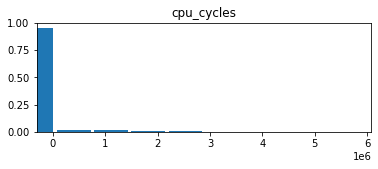

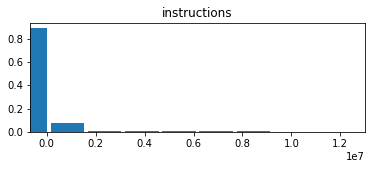

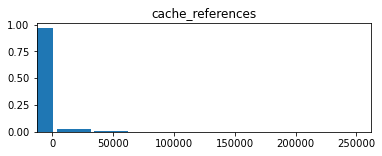

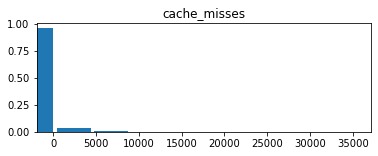

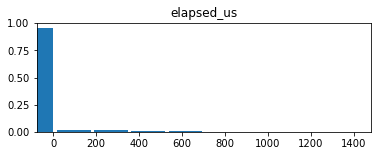

In [45]:
plot_histograms(targets)

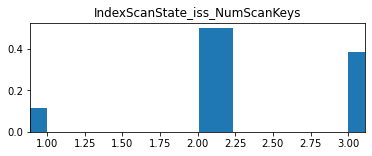

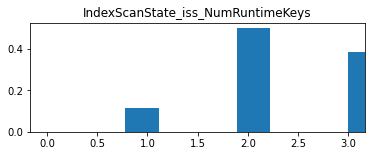

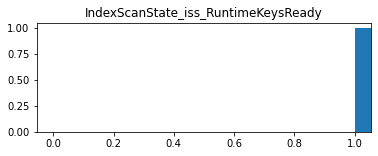

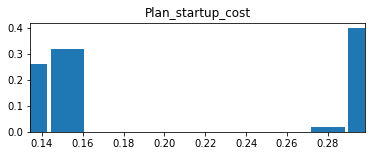

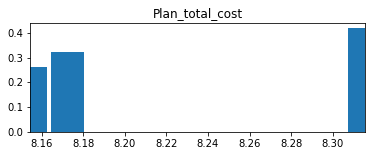

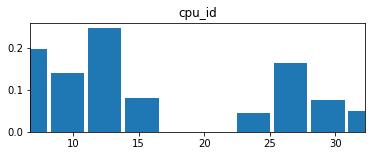

In [46]:
plot_histograms(features)

#### Correlation Heatmap

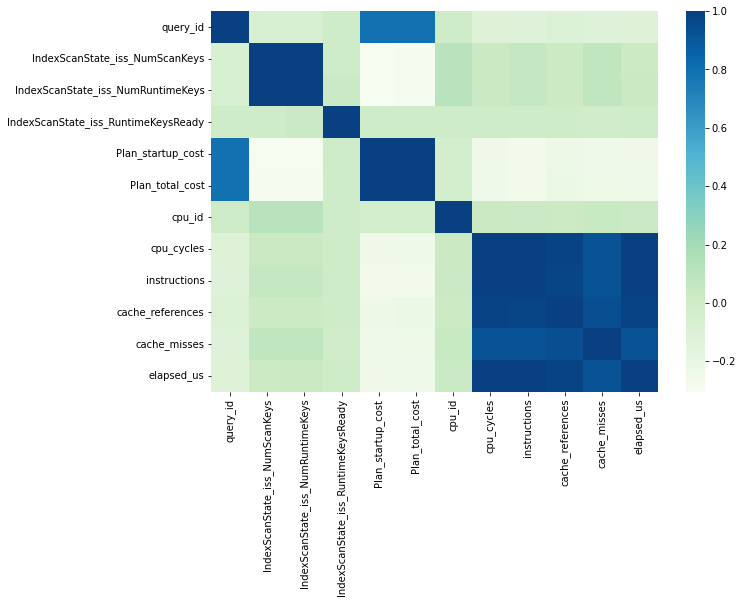

In [47]:
df_corr = df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(df_corr, cmap='GnBu')
plt.show()

# Feature Analysis (PCA)

In [23]:
features

,IndexScanState_iss_NumScanKeys,IndexScanState_iss_NumRuntimeKeys,IndexScanState_iss_RuntimeKeysReady,Plan_startup_cost,Plan_total_cost,cpu_id
0,1,1,1,0.2900,8.3075,15
1,1,1,1,0.1450,8.1625,15
2,1,1,1,0.2900,8.3075,15
3,1,1,1,0.1450,8.1625,15
4,1,1,1,0.2900,8.3075,15
...,...,...,...,...,...,...
375947,2,2,1,0.2875,8.3075,26
375948,3,3,1,0.1525,8.1750,26
375949,2,2,1,0.2875,8.3075,26
375950,3,3,1,0.1525,8.1750,26


## Feature Analysis - PCA

In [24]:
def pca_summary(df):
    pca = PCA(n_components=None)
    pca.fit(df)
    print(f"Input Dimensionality: {len(df.columns)}")
    for component_idx, explained_var_pct in enumerate(pca.explained_variance_ratio_):
        print(f"Component {component_idx} explains {round(explained_var_pct*100, 2)}% of variance")

In [25]:
pca_summary(features)

Input Dimensionality: 6
Component 0 explains 98.58% of variance
Component 1 explains 1.4% of variance
Component 2 explains 0.01% of variance
Component 3 explains 0.0% of variance
Component 4 explains 0.0% of variance
Component 5 explains 0.0% of variance


In [26]:
scanstate_feats = ['IndexScanState_iss_NumScanKeys', 'IndexScanState_iss_NumRuntimeKeys', 'IndexScanState_iss_RuntimeKeysReady']
pca_summary(features[scanstate_feats])

Input Dimensionality: 3
Component 0 explains 99.96% of variance
Component 1 explains 0.04% of variance
Component 2 explains 0.0% of variance


In [27]:
plancost_feats = ['Plan_startup_cost', 'Plan_total_cost']
pca_summary(features[plancost_feats])

Input Dimensionality: 2
Component 0 explains 99.99% of variance
Component 1 explains 0.01% of variance
